# Import libraries

In [1]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Built-in libraries
#
import time
import pandas as pd
import numpy  as np


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization libraries
#
import matplotlib.pyplot as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# FB-Prophet libraries
#
import fbprophet


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# User libraries
#
from utils.optimize_prophet_changepoint import *
from utils.PerformanceMetrics           import *

# Import data

In [2]:
# Start timer
#
start = time.time()

df = pd.read_csv('Data/Temperature.csv')

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

[INFO] Data imported
[INFO] Time: 0.01 seconds


## Preprocess

In [4]:
df = df[ ['Date', 'Temperature'] ]
df = df.rename(columns = {'Date':'ds', 'Temperature':'y'})

df['ds'] = df['ds'].astype('datetime64')
df.set_index('ds', inplace=True)

In [5]:
df.head(3)

,y
ds,
2015-02-11 14:48:00,21.7600
2015-02-11 14:49:00,21.7900
2015-02-11 14:50:00,21.7675


## Training/Testing sets

In [9]:
# Create training/testing dfsets
#
idx = int( df.shape[0] * 0.9)

df_train = df.iloc[ :idx ]
df_test  = df.iloc[ idx: ]


Horizon = df_test.shape[0]

print('Horizon: ', Horizon)

Horizon:  976


## Visualization

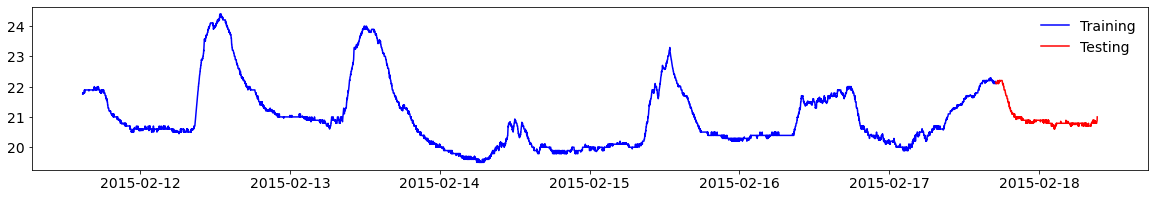

In [10]:
plt.figure( figsize=(20, 3) );

plt.plot(df_train, color='b')
plt.plot(df_test,  color='r')

plt.legend(['Training', 'Testing'], fontsize=14, frameon=False);
plt.xticks(size=14);
plt.yticks(size=14);

## Scale data

In [11]:
# # Set scaler
# #
# scaler = StandardScaler()


# # Scaling - Training set
# #
# df_train = pd.DataFrame(scaler.fit_transform(df_train),
#                         columns = df_train.columns,
#                         index   = df_train.index)

# # Scaling - Testing set
# #
# df_test = pd.DataFrame(scaler.transform(df_test),
#                         columns = df_test.columns,
#                         index   = df_test.index)

## Prophet model

### Changepoint optimization

In [12]:
# Setting the parameter to the optimal parameter identified by the optimization function.
#
initial_changepoint = 0.1
step                = 0.1
nIterations         = 10


# Optimization process
#
changepoint = optimize_prophet_changepoint(data          = df_train.reset_index(), 
                                           initial_param = initial_changepoint, 
                                           step          = step, 
                                           nIterations   = nIterations)


print('[INFO] Changepoint optimized:',changepoint)

### Model setup & training

In [23]:
# Parameters
#
interval_width = 0.95
changepoint    = 0.9

# Setup model
#
model = fbprophet.Prophet(daily_seasonality  = True, 
                          yearly_seasonality = False, 
                          weekly_seasonality = False,
                          seasonality_mode   = 'additive', 
                          interval_width     = interval_width,
                          changepoint_range  = changepoint)



# Start timer
#
start = time.time()

# Train model
#
model.fit( df_train.reset_index() ) 

print('[INFO] Model trained')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

[INFO] Model trained
[INFO] Time: 16.04 seconds


## Forecasting

### Concatenate training & testing data

In [24]:
# Concatenate training & testing data
#
df = pd.concat([df_train, df_test]).reset_index()

# Reset index. Required by Prophet for forecasting
#
df = df.reset_index()

### Application of Prophet model

In [25]:
# Start timer
#
start = time.time()

# Train model
#
forecast = model.predict( df )


print('[INFO] Forecasts conducted')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

[INFO] Forecasts conducted
[INFO] Time: 3.64 seconds


In [26]:
# Store real values along with forecasts
#
forecast['y'] = df['y']

Text(156.25, 0.5, 'Temperature')

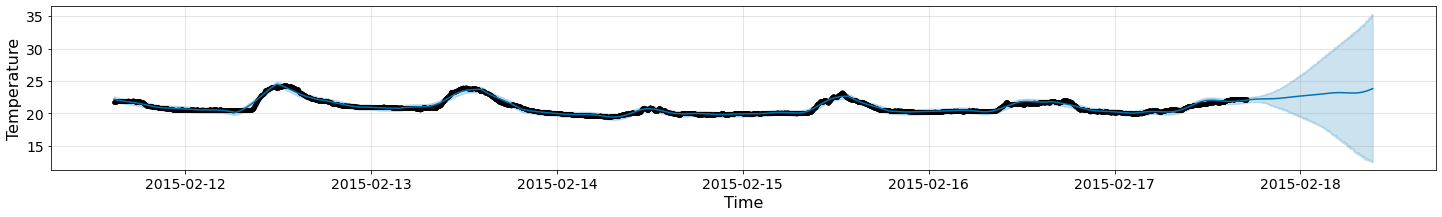

In [27]:
#plot the model forecast chart with component charts in trend and seasonality 
#
model.plot( forecast, figsize=(20, 3))

plt.yticks(size=14);
plt.xticks(size=14);

plt.xlabel('Time', size=16)
plt.ylabel('Temperature', size=16)

### Prophet evaluation on training set

In [28]:
# Get all information on the training set
#
data = forecast[ :df_train.shape[0] ]

print( "> RMSE:  ", rmse(data['y'],  data['yhat']) )
print( "> MAE:   ", mae(data['y'],   data['yhat']) )
print( "> MAPE:  ", mape(data['y'],  data['yhat']) )
print( "> SMAPE: ", smape(data['y'], data['yhat']) )
print( "> R2:    ", R2(data['y'],    data['yhat']) )

> RMSE:   0.2063056273715208
> MAE:    0.15221319226969604
> MAPE:   0.7126732158373122
> SMAPE:  0.7125109531534825
> R2:     0.9626439592160221


### Prophet evaluation on testing set

In [29]:
# Get all information on the training set
#
data = forecast[ df_train.shape[0]: ]


print( "> RMSE:  ", rmse(data['y'],  data['yhat']) )
print( "> MAE:   ", mae(data['y'],   data['yhat']) )
print( "> MAPE:  ", mape(data['y'],  data['yhat']) )
print( "> SMAPE: ", smape(data['y'], data['yhat']) )
print( "> R2:    ", R2(data['y'],    data['yhat']) )

> RMSE:   1.947852122004111
> MAE:    1.7938300630148079
> MAPE:   8.609877005936704
> SMAPE:  8.194018716488502
> R2:     -22.210659194235014


## Prediction visualization

In [30]:
pred = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

pred = pred.set_index('ds')

pred = pred[-Horizon:]

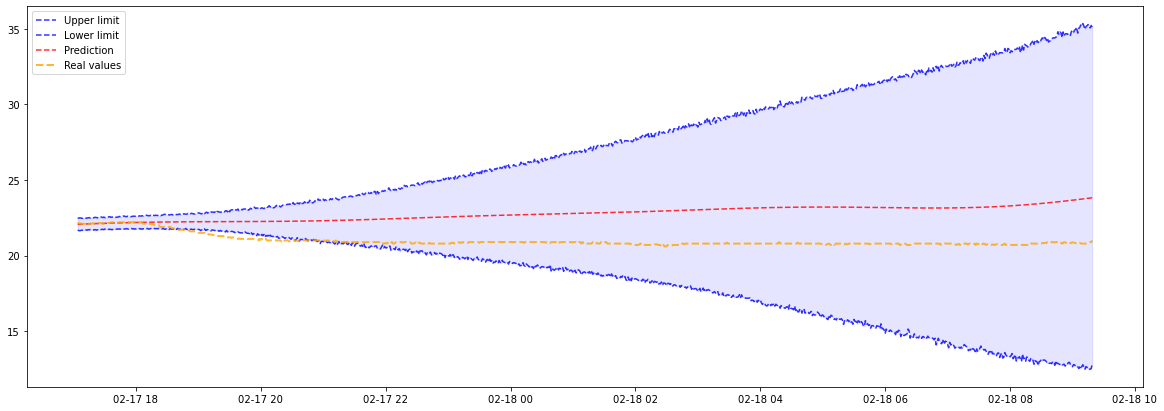

In [31]:
plt.figure( figsize=(20,7) )

# Plot Upper/Lower limits
#
plt.plot(pred.index, pred.yhat_upper,  color='blue', linestyle='--', alpha=0.8)
plt.plot(pred.index, pred.yhat_lower,  color='blue', linestyle='--', alpha=0.8)

# Plot predictions
#
plt.plot(pred.index, pred.yhat,  color='red', linestyle='--', alpha=0.8)

# Plot real values
#
plt.plot(df_test.index, df_test.y,  color='orange', linestyle='--', linewidth=2, alpha=0.8)



# Fill between Upper-Lower lines
#
plt.fill_between(pred.index, pred.yhat_upper, pred.yhat_lower, color='blue', alpha=0.1)

plt.legend(['Upper limit', 'Lower limit', 'Prediction', 'Real values'])

<AxesSubplot:>

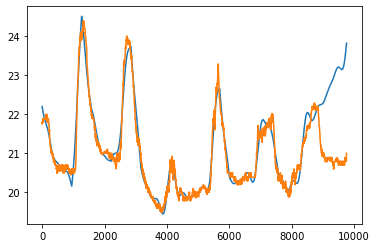

In [32]:
forecast['yhat'].plot()
forecast['y'].plot()